# Named entity recognition

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

## Tasks

1. Read the classification of [Named Entities](http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf).

In [1]:
import spacy
from spacy.tokenizer import *
import regex
import string
from tqdm import tqdm
import xml.etree.ElementTree as ET
import requests
import glob
import os
from collections import Counter
import matplotlib.pyplot as plt
import re
from termcolor import colored
import locale

locale.setlocale(locale.LC_COLLATE, "pl_PL.UTF-8")


2021-12-19 16:03:34.401234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-19 16:03:34.401267: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'pl_PL.UTF-8'

2. Read the [API of NER](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki) in [Clarin](http://ws.clarin-pl.eu/ner.shtml).

3. Read the [documentation of CLL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).
4. Sort bills according to their size and take top 50 (largest) bills.

In [2]:

dir_name = '../data/ustawy/'
# Get a list of files (file paths) in the given directory 
list_of_files = filter( os.path.isfile,
                        glob.glob(dir_name + '*') )

# Sort list of files in directory by size 
list_of_files = sorted( list_of_files,key =  lambda x: os.stat(x).st_size)

list_of_files = list_of_files[-50:]
print(len(list_of_files))

for elem in list_of_files:
    file_size  = os.stat(elem).st_size 
    print(file_size, ' -->', elem)   


50
133784  --> ../data/ustawy/2001_1444.txt
136489  --> ../data/ustawy/1997_153.txt
141328  --> ../data/ustawy/1996_496.txt
142132  --> ../data/ustawy/2001_92.txt
143601  --> ../data/ustawy/2001_906.txt
148194  --> ../data/ustawy/1998_602.txt
148449  --> ../data/ustawy/2003_2256.txt
149411  --> ../data/ustawy/2001_475.txt
150870  --> ../data/ustawy/2001_628.txt
152985  --> ../data/ustawy/2001_1188.txt
154639  --> ../data/ustawy/1996_561.txt
161341  --> ../data/ustawy/2001_1438.txt
163118  --> ../data/ustawy/1996_460.txt
168282  --> ../data/ustawy/2000_136.txt
174145  --> ../data/ustawy/2001_1381.txt
175787  --> ../data/ustawy/1999_95.txt
178805  --> ../data/ustawy/1997_557.txt
179878  --> ../data/ustawy/1996_110.txt
180335  --> ../data/ustawy/2004_2533.txt
182152  --> ../data/ustawy/1994_591.txt
182337  --> ../data/ustawy/1999_930.txt
183107  --> ../data/ustawy/2000_1315.txt
188718  --> ../data/ustawy/1997_349.txt
190810  --> ../data/ustawy/2003_423.txt
212340  --> ../data/ustawy/2004_

In [3]:
# !python -m spacy download pl_core_news_sm

5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive
   words starting with a capital letter (you will have to look at the inflected form of the word to check its
   capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
   ```
   Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.
   ```
   should yield the following entries: `Kraków`, `Polska`, `Stan Zjednoczony`.

In [4]:
nlp = spacy.load("pl_core_news_sm")
tokenizer = Tokenizer(nlp.vocab)

tokens_list = []
tokens = []

for filename in tqdm(list_of_files):
    with open(filename, "r", encoding="utf-8") as file:
        act = file.read()
        act = regex.sub(r"\s+", " ", act)
        act = regex.sub(r"­", "", act)
        
        tokens += [token for token in tokenizer(act)]

        tokens_list += [token.text for token in tokenizer(act)]


old_tokens_list = tokens_list


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.59it/s]


In [5]:
import morfeusz2
morf = morfeusz2.Morfeusz()

def is_upper(token):
    if token[0].islower(): # words that start with a lower case are lower
        return False
    
    analysis = morf.analyse(token) # otherwise we check word base form to obtain an information whether it is uppercase or not
#     print(analysis)
    for a in analysis:
        if a[2][1][0].isupper():
            return True
    return False

print(is_upper("USA"))
print(is_upper("Pies"))
print(is_upper(","))
print(is_upper('Stanów'))

True
False
False
True


In [6]:
def separate_puctuations(tokens):
    new_tokens = []
    for token in tokens:
        splitted = regex.findall(
            r"[\w']+|[.,!?;]", token
        )  # https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation
        new_tokens += splitted
    return new_tokens


In [7]:
tokens = separate_puctuations(tokens_list)

In [8]:


def compute_ners(tokens):
    ners = []
    ner = ""
    phrase = False
    for i in range(1,len(tokens)):
        if not phrase and is_upper(tokens[i]) and tokens[i-1]!=".": #beginning of sequence
            phrase = True
        elif phrase and (not tokens[i][0].isupper() or tokens[i]=="."): # end of sequence
            ners.append(ner)
            phrase = False
            ner = ""

        if phrase:
            ner+=f" {tokens[i]}"
    return ners

# wynik jeszcze przed lematyzacją
compute_ners("Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych .".split(" "))


[' Krakowie', ' Polski', ' Stanów Zjednoczonych']

6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [9]:
ners = compute_ners(tokens)
Counter(ners).most_common(50)

[(' Art', 2009),
 (' Dz', 1486),
 (' Polskiej', 795),
 (' Obrony Narodowej', 315),
 (' Straży Granicznej', 311),
 (' Unii Europejskiej', 289),
 (' Straży Pożarnej', 234),
 (' Kasy Chorych', 185),
 (' I', 146),
 (' Pracy', 139),
 (' II', 118),
 (' Zdrowia', 109),
 (' Wolnym Handlu EFTA', 103),
 (' P2O5', 100),
 (' Związku Kas', 98),
 (' Maszyny', 95),
 (' Damskie', 93),
 (' Nawóz', 93),
 (' Skarb Państwa', 91),
 (' Opieki Społecznej', 89),
 (' III', 87),
 (' BSWSG', 69),
 (' L', 68),
 (' Głównego Urzędu Ceł', 66),
 (' Dzienniku Urzędowym Rzeczypospolitej Polskiej Monitor Polski', 65),
 (' BSWP', 64),
 (' CN', 60),
 (' Rada Ministrów', 52),
 (' Rzeczpospolita Polska', 52),
 (' Polsce', 51),
 (' PESEL', 50),
 (' Polskiej Dz', 48),
 (' Związku Kas Chorych', 48),
 (' BOR', 47),
 (' Kas Chorych', 44),
 (' Gospodarki', 42),
 (' Warszawie', 39),
 (' Banku Polskiego', 39),
 (' Rzeczpospolitą Polską', 39),
 (' IV', 39),
 (' MgO', 39),
 (' K2O', 39),
 (' Głównego Urzędu Statystycznego', 36),
 (' 

In [10]:
def lemmatize(doc):
    return " ".join([token.lemma_ for token in nlp(doc)]) 

                     


ners = [ lemmatize(ner).title() for ner in ners ]
Counter(ners).most_common(50)

[('  Art', 2011),
 ('  Dz', 1486),
 ('  Polski', 865),
 ('  Straża Graniczny', 321),
 ('  Obrona Narodowy', 315),
 ('  Kasa Chory', 311),
 ('  Unia Europejski', 296),
 ('  Straża Pożarny', 240),
 ('  I', 146),
 ('  Praca', 139),
 ('  Nawóz', 127),
 ('  Ii', 118),
 ('  Wolny Handel Efta', 112),
 ('  Zdrowie', 109),
 ('  Związek Kasa', 100),
 ('  P2O5', 100),
 ('  Maszyna', 95),
 ('  Damski', 93),
 ('  Skarba Państwo', 91),
 ('  Rzeczpospolita Polska', 91),
 ('  Opieka Społeczny', 89),
 ('  Iii', 87),
 ('  Bank Polski', 72),
 ('  Warszawa', 71),
 ('  Polska', 70),
 ('  Bswsg', 69),
 ('  L', 68),
 ('  Główny Urząd Cło', 66),
 ('  Dziennik Urzędowy Rzeczypospolitej Polski Monitor Polska', 65),
 ('  Bswp', 64),
 ('  Cn', 60),
 ('  Rado Minister', 52),
 ('  Polski Dz', 52),
 ('  Pesel', 50),
 ('  Związek Kasa Chory', 50),
 ('  Bor', 47),
 ('  Gospodarka', 42),
 ('  Główny Straża Graniczny', 39),
 ('  Iv', 39),
 ('  Mgo', 39),
 ('  K2O', 39),
 ('  Pan', 38),
 ('  Główny Policja', 36),
 ('  Gł

## 7. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the `n82` model.

In [249]:
user='myemail@gmail.com'

url='http://ws.clarin-pl.eu/nlprest2/base'
lpmn='any2txt|wcrft2|liner2({"model":"n82"})'

headers ={'Content-Type': 'binary/octet-stream'}
headers1 = {'Content-Type': 'application/json'}

in_path = 'paczka/*'
out_path= 'out/'

def start_task(doc : string):
    req = requests.post(f'{url}/upload',data=doc,headers=headers)
    fileid = req.text
    data={'lpmn':lpmn,'user':user,'file':fileid}


    taskid = requests.post(f'{url}/startTask/',json=data).text
    return taskid
    
def wait(taskid : string) ->string:
    resp = requests.get(f'{url}/getStatus/{taskid}').text
    data = json.loads(resp)
    i=0
    while data["status"] == "QUEUE" or data["status"] == "PROCESSING" :
        resp = requests.get(f'{url}/getStatus/{taskid}').text
        data = json.loads(resp)

        if data["status"]=="ERROR":
            print("Error "+data["value"]);
            return None
        time.sleep(1.0)
        i+=1
#         if i%30==0:
#             print(i,data["status"] )
    data = data["value"]
    if data!=None:
        return data[0]["fileID"]
    return None

def save(file,fileid):
    content = requests.get(f'{url}/download{fileid}')
    with open (f'{out_path}/{os.path.basename(file)}.ccl', "w") as outfile:
        outfile.write(content.text)
    

taskids = [ ]
for filename in list_of_files:
    with open(filename, "rb") as myfile:
        doc=myfile.read()
        taskid = start_task(doc)
        taskids.append(taskid)

for filename,taskid in tqdm(zip(list_of_files,taskids)):
    fileid = wait(taskid)
    save(filename,fileid)

# for filename in ['paczka/file.txt']:
#     with open (filename, "rb") as myfile:
#         doc=myfile.read()
#         taskid = start_task(doc)

#         fileid = wait(taskid)
#         save(filename,fileid)


50it [16:07, 19.36s/it]


In [11]:
# Źródło https://github.com/CLARIN-PL/NlpRest2-Tutorials/blob/master/part3.ipynb

class Token:
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag
        
    def get_orth(self): # Sejmu
        return self.orth
    
    def get_base(self): #sejm
        return self.base
    
    def get_ctag(self): #subst:sg:gen:m3
        return self.ctag
        

class Annotation:
    
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()
        
    def get_category(self): # nam_org_institution
        return self.category
    
    def get_tokens(self):
        return self.tokens
    
    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens]) #Sejmu Rzeczypospolitej Polskiej

    def get_base(self):
        return " ".join([token.get_base() for token in self.tokens]) #'sejm rzeczpospolita polski
    
    def get_ctag(self):
        return " ".join([token.get_ctag() for token in self.tokens]) #subst:sg:gen:m3 subst:sg:gen:f adj:sg:gen:f:pos
    
    def get_space(self):
        return " ".join(["True" for token in self.tokens]) # True True True
    
    def get_lemma(self):  #Sejmu Rzeczypospolitej Polskiej
        return self.lemma
    
    def set_lemma(self, lemma):
        self.lemma = lemma
        
    def get_coarse_category(self):
        return re.findall('^[a-z]+_[a-z]+',self.category)[0]

    def __str__(self): 
        return "[%s] %s" % (self.get_category(), self.get_lemma())

    
    

def sentence_ner(sentence):
    channels = {} # '{ nam_loc_astronomical' : {1: [token_Układzie, token_Słonecznym]}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):   #  <ann chan="nam_org_institution">0</ann>          
            index = int(channel.text) # 0
            chan = channel.attrib["chan"] #  nam_org_institution          
            if index > 0:                
                channels.setdefault(chan, {}).setdefault(index, []).append(t) # channels['nam_loc_astronomical']['1'].append(token)
                
    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():            
            an = Annotation(ann_type, tokens)
            annotations.append(an)
    
    return annotations
                

def ccl_ner(ccl):
    tree = ET.fromstring(ccl)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations



# Test on a single document
# with open('2001_1444.txt.ccl',"r") as file:
#     ccl = file.read()
#     annotations = ccl_ner(ccl)
#     for annotation in annotations:
#         print(annotation)

annotations = [] 
ccl_files = list(filter( os.path.isfile, glob.glob(f'out1/*') ))
for ccl_file in ccl_files:
    with open(ccl_file,"r") as file:
        ccl = file.read()
        annotations += ccl_ner(ccl)
        

        

8. Plot the frequency (histogram) of the coarse-grained classes (e.g. `nam_adj`, `nam_eve`, `nam_fac`).

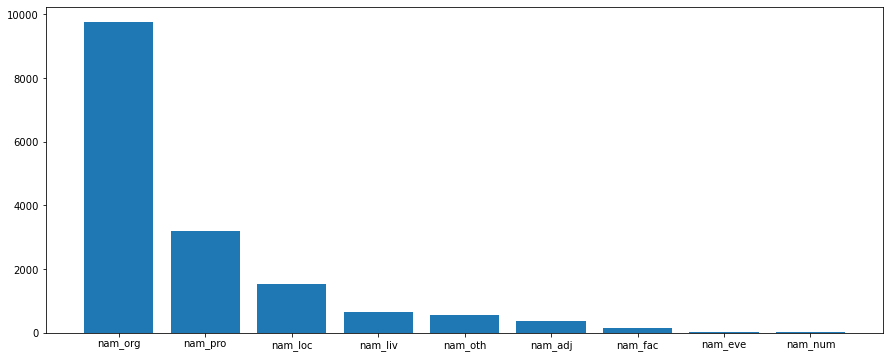

In [12]:



categories = [a.get_coarse_category() for a in annotations]
c = Counter(categories)

# wyjaśnienie nazw kategori
# http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki/Liner2_nazwy
fig = plt.figure(figsize=(15,6))
category_name, count = list(zip(*c.most_common()))
plt.bar(category_name,count)
plt.show()

9. Display 10 most frequent Named Entities for each coarse-grained type.

In [13]:

ners10 = {c:[] for c in category_name}

for a in annotations:
    ners10[a.get_coarse_category()].append(a.get_orth())

In [14]:
[(cat,Counter(ners).most_common(10)) for (cat , ners) in ners10.items()]

[('nam_org',
  [('Skarbu Państwa', 295),
   ('Unii Europejskiej', 291),
   ('Rada Ministrów', 261),
   ('Państwowej Straży Pożarnej', 239),
   ('Minister Sprawiedliwości', 233),
   ('Prezes Rady Ministrów', 213),
   ('Minister Obrony Narodowej', 162),
   ('Minister Finansów', 152),
   ('Urzędu Ochrony Państwa', 137),
   ('EFTA', 114)]),
 ('nam_pro',
  [('Dz . U .', 1534),
   ('Dz . Urz', 80),
   ('Ordynacja podatkowa', 71),
   ('Kodeksu karnego', 64),
   ('Monitor Polski', 62),
   ('Spraw Wewnętrznych', 51),
   ('Kodeksu postępowania administracyjnego', 35),
   ('Kodeksu postępowania karnego', 33),
   ('Kodeksu postępowania cywilnego', 32),
   ('Natura 2000', 26)]),
 ('nam_loc',
  [('Rzeczypospolitej Polskiej', 812),
   ('Rzeczpospolita Polska', 52),
   ('Polsce', 51),
   ('Rzeczpospolitą Polską', 39),
   ('Warszawie', 32),
   ('Warszawy', 20),
   ('Nawóz', 19),
   ('Warszawa', 16),
   ('Konfederacji Szwajcarskiej', 11),
   ('Polską', 10)]),
 ('nam_liv',
  [('Kasa Chorych', 51),
   ('S

10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [15]:
import pandas as pd
finegrained = {a.get_orth() : a.get_category() for a in annotations}


ner, count = list(zip(*Counter([a.get_orth() for a in annotations]).most_common(50)))
category = [finegrained[n] for n in ner]
pd.DataFrame({'ner': ner,'count':count, 'fine-grained category':category})

,ner,count,fine-grained category
0,Dz . U .,1534,nam_pro_media_periodic
1,Rzeczypospolitej Polskiej,812,nam_loc_gpe_country
2,Skarbu Państwa,295,nam_org_institution
3,zł,293,nam_oth_currency
4,Unii Europejskiej,291,nam_org_organization
5,Rada Ministrów,262,nam_org_institution
6,Państwowej Straży Pożarnej,239,nam_org_organization
7,Minister Sprawiedliwości,233,nam_org_institution
8,Prezes Rady Ministrów,213,nam_org_institution
9,Minister Obrony Narodowej,162,nam_org_institution


11. Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.
   (For demo application [Streamlit](https://streamlit.io/) might be useful for displaying NER results).

In [16]:
text='Jest również szeroko rozpowszechniona w Układzie Słonecznym : stanowi istotny element budowy Ceres i księżyców lodowych krążących wokół planet - olbrzymów , jako domieszka występuje w ich atmosferach , a przypuszcza się , że duże jej ilości znajdują się we wnętrzach tych planet .'
def color(sentence, words):
    for word in words:
        sentence =sentence.replace(word,colored(word, 'white','on_red')) 
    return (sentence)
    
print(color(text,['Układzie Słonecznym']))


Jest również szeroko rozpowszechniona w Układzie Słonecznym : stanowi istotny element budowy Ceres i księżyców lodowych krążących wokół planet - olbrzymów , jako domieszka występuje w ich atmosferach , a przypuszcza się , że duże jej ilości znajdują się we wnętrzach tych planet .


In [17]:
def ccl_ner_graphical(ccl): # specjalna wersja do zadania 11 tutaj chcemy zachowac całe zdania
    tree = ET.fromstring(ccl) 
    sentence_annotations = [] # [["Ziemia","Układzie Słonecznym"],[],..]
    sentence_text = []     # ["Ziemia jest w Układzie Słonecznym", " ",...]
    
    for sentence in tree.iter("sentence"):
        sentence_annotations.append(sentence_ner(sentence))
        text = " ".join([token.find("./orth").text for token in sentence.iter("tok")])
        sentence_text.append(text)
    return [sentence_annotations,sentence_text]




In [18]:
sentence_text = []
sentence_annotations = [] 
for ccl_file in ccl_files:
    with open(ccl_file,"r") as file:
        ccl = file.read()
        ann, text = ccl_ner_graphical(ccl)
        sentence_annotations+=ann
        sentence_text+=text
    

In [19]:
for sentence, ner in zip(sentence_text,sentence_annotations):
    ner_tokens = [n.get_orth() for n in ner]
    ner_cat =   [n.get_coarse_category() for n in ner]
    uniq_categories_number = len(set(ner_cat))
    if uniq_categories_number >1:

        print(color(sentence,ner_tokens),ner_tokens, ner_cat,uniq_categories_number)
        print()


Ordynacja wyborcza do Sejmu Rzeczypospolitej Polskiej i do Senatu Rzeczypospolitej Polskiej ['Ordynacja wyborcza do Sejmu Rzeczypospolitej Polskiej i do Senatu Rzeczypospolitej Polskiej', 'Sejmu Rzeczypospolitej Polskiej', 'Senatu Rzeczypospolitej Polskiej'] ['nam_pro', 'nam_org', 'nam_org'] 2

Postanowienie Prezydenta Rzeczypospolitej podaje się do wiadomości publicznej i ogłasza w Dzienniku Ustaw Rzeczypospolitej Polskiej najpóźniej w 5 dniu od dnia zarządzenia wyborów . ['Postanowienie Prezydenta Rzeczypospolitej', 'Dzienniku Ustaw Rzeczypospolitej Polskiej', 'Dzienniku'] ['nam_org', 'nam_org', 'nam_pro'] 2

Postanowienie Prezydenta Rzeczypospolitej o zarządzeniu wyborów podaje się do wiadomości publicznej i ogłasza w Dzienniku Ustaw Rzeczypospolitej Polskiej najpóźniej w 5 dniu od dnia jego podpisania . ['Postanowienie Prezydenta Rzeczypospolitej', 'Dzienniku Ustaw Rzeczypospolitej Polskiej', 'Dzienniku'] ['nam_org', 'nam_org', 'nam_pro'] 2

Postanowienie , o którym mowa w ust . 3 

W ustawie z dnia 20 lutego 1997 r . o stosunku Państwa do Kościoła Zielonoświątkowego w Rzeczypospolitej Polskiej ( Dz . U . Nr 41 , poz . 254 i z 1998 r . ['Kościoła Zielonoświątkowego', 'Rzeczypospolitej Polskiej', 'Dz . U .'] ['nam_org', 'nam_loc', 'nam_pro'] 3

W skład Urzędu Regulacji Energetyki wchodzą Oddział Centralny w Warszawie oraz następujące oddziały terenowe : 1 ) północno - zachodni z siedzibą w Szczecinie , 2 ) północny z siedzibą w Gdańsku , 3 ) zachodni z siedzibą w Poznaniu , 4 ) wschodni z siedzibą w Lublinie , 5 ) środkowo - zachodni z siedzibą w Łodzi , 6 ) południowo - zachodni z siedzibą we Wrocławiu , 7 ) południowy z siedzibą w Katowicach , 8 ) południowo - wchodni z siedzibą w Krakowie . ['Urzędu Regulacji Energetyki wchodzą Oddział Centralny', 'Warszawie', 'Szczecinie', 'Gdańsku', 'Poznaniu', 'Lublinie', 'Łodzi', 'Wrocławiu', 'Katowicach', 'Krakowie'] ['nam_org', 'nam_loc', 'nam_loc', 'nam_loc', 'nam_loc', 'nam_loc', 'nam_loc', 'nam_loc', 'nam_loc', 'nam_loc

W ustawie z dnia 24 czerwca 1994 r . o restrukturyzacji banków spółdzielczych i Banku Gospodarki Żywnościowej oraz o zmianie niektórych ustaw ( Dz . U . Nr 80 , poz . 369 i z 1995 r . ['Banku Gospodarki Żywnościowej', 'Dz . U .'] ['nam_org', 'nam_pro'] 2

W ustawie z dnia 7 lipca 1994 r . o gwarantowanych przez Skarb Państwa ubezpieczeniach kontraktów eksportowych ( Dz . U . Nr 86 , poz . 398 ) wprowadza się następujące zmiany : 1 ) w art . 8 ust . 2 otrzymuje brzmienie : " 2 . ['Skarb Państwa', 'Dz . U .'] ['nam_org', 'nam_pro'] 2

Minister Gospodarki , w porozumieniu z Ministrem Finansów określa , w drodze rozporządzenia , minimalny procentowy udział składników pochodzenia krajowego w eksportowanym produkcie finalnym , umożliwiającym uznanie tego produktu za krajowy . " ; 2 ) w art . 9 ust . 1 otrzymuje brzmienie : " 1 . ['Gospodarki', 'Ministrem Finansów'] ['nam_liv', 'nam_org'] 2

2 pkt 1 , nie stosuje się do tych budynków . " ; 2 ) w art . 10 w ust . 3 wyrazy ` Minister Gospodarki

1 . BSWSG jest jednostką organizacyjną Straży Granicznej realizującą na obszarze całego kraju zadania w zakresie rozpoznawania , zapobiegania i zwalczania przestępczości popełnianej przez funkcjonariuszy i pracowników Straży Granicznej , przestępstw przeciwko obrotowi gospodarczemu popełnianych na szkodę Straży Granicznej , określonych w art . 296 – 306 Kodeksu karnego oraz wykrywania i ścigania sprawców tych przestępstw , a także – w zakresie zleconym przez Inspektora Nadzoru Wewnętrznego – funkcjonariuszy i pracowników Policji i Biura Ochrony Rządu lub strażaków i pracowników Państwowej Straży Pożarnej . ['BSWSG', 'Państwowej Straży Pożarnej', 'Straży Granicznej', 'Straży Granicznej', 'Inspektora Nadzoru Wewnętrznego', 'Biura Ochrony Rządu', 'Straży Granicznej', 'Kodeksu karnego'] ['nam_org', 'nam_org', 'nam_org', 'nam_org', 'nam_org', 'nam_org', 'nam_fac', 'nam_pro'] 3

Siedzibą Komendanta BSWSG jest miasto stołeczne Warszawa . ['BSWSG', 'Warszawa'] ['nam_org', 'nam_loc'] 2

Kierown

Minister Edukacji Narodowej jest obowiązany zapewnić uwzględnianie problematyki bezpieczeństwa i higieny pracy oraz ergonomii w programach nauczania w szkołach , po uzgodnieniu zakresu tej problematyki z Ministrem Pracy i Polityki Socjalnej . ['Minister Edukacji Narodowej', 'Ministrem Pracy i Polityki Socjalnej'] ['nam_oth', 'nam_org'] 2

Minister Pracy i Polityki Socjalnej określi , w drodze rozporządzenia , sposób usprawiedliwiania nieobecności w pracy oraz zakres przysługujących pracownikom zwolnień od pracy , a także przypadki , w których za czas nieobecności lub zwolnienia pracownik zachowuje prawo do wynagrodzenia . " ; 209 ) skreśla się art . 299 ; 210 ) w art . 301 w § 1 wyrazy " Polskiej Rzeczypospolitej Ludowej " zastępuje się wyrazami " Rzeczypospolitej Polskiej " ; 211 ) w art . 302 wyrazy " w organach Milicji Obywatelskiej i Służby Więziennej " zastępuje się wyrazami " w Policji , Urzędzie Ochrony Państwa , Służbie Więziennej , Straży Granicznej i Państwowej Straży Pożarne

12. Answer the following questions:
   
   
#### 1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?
      
Zaryzykowałbym, że NER, ponieważ daje bardziej szczegółowe informacje (o kategoriach) i jest to narzędzie, które zostało do tego domyślnie przeznaczone. Otrzymane 50 najczęstszych wyrażeń jest lepsze niż w przypadku capital letters



#### 2. What are the drawbacks of the method based on capital letters?

Nie mamy podziału na poszczególne kategorie.
Bardzo dużo rzeczy możnaby wychwywywać recznie: np. odflitrować cyfry rzymskie, numery podpunktów.


#### 3. What are the drawbacks of the method based on NER?

NER została specjalnie przygotowana do tego rodzaju zadań. Mamy podział na kategorie i podkategorie.

Pojawiają się zduplikowane wpisy wynikające z innej formy fleksyjnej

Niestety (choć rzadko) niektóre słowa nie zawsze zostają odpowiednio zaklasyfikowane. W poniższym zdaniu skrót FUS Fundusz Ubezpieczeń Społecznych czyli nam_org został oznaczony równiez jako nam_pro
```

Ze środków zgromadzonych w FUS finansowane są : 1 ) wypłaty świadczeń z ubezpieczenia emerytalnego , rentowego , chorobowego oraz wypadkowego , 2 ) wydatki na prewencję rentową , 3 ) spłaty kredytów i pożyczek wraz z odsetkami , zaciąganych w celu wypłaty świadczeń z FUS , ['FUS', 'FUS'] ['nam_org', 'nam_pro'] 2

```



#### 4. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.
  
Korzystając z dokumentacji:
http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki/Liner2_nazwy

nam_loc, nam_adj mają bardzo dobrze przygotowane przykłady, 

do nam_other pomyślnie trafiają informacje dotyczące walut

nam_fac ma przykłady bardzo źle dobrane, w tej kategorii powinny znaleźć się budowle

nam_eve w tej kategorii powinny być wydarzenia, a są inne wyrażenia np. "Generalny Konserwator Zabytków"

Myślę, że problemy z poprawnym przypisywaniem do tych kategorii mogą wynikać z tego że analizujemy korpus ustaw, o wyspecjalizownym prawniczym języku.
  
  
#### 5. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and
  "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that
  would be able to group such names together?
  
Myślę że nie. Spacy ze słownikiem synonimów byłoby dobrą alternatywą. Robiliśmy to na jednych z pierwszych zajęć

#### 6. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?


Na przykład zastosowanie NER do analizy postów na Twiterze/blogach. 

Można by je było użyć do analizy tematyki artykułów

Asystent głosowy